<a href="https://colab.research.google.com/github/Ravi110296/Group_16_DL_Assignment1/blob/main/DL_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random

SEED = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Validation split from training set
val_size = 5000
train_size = len(train_full) - val_size

train_dataset, val_dataset = random_split(
    train_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

classes = train_full.classes


100%|██████████| 170M/170M [01:18<00:00, 2.16MB/s]


In [ ]:
from torchvision.models import resnet18

def get_resnet18_cifar():
    model = resnet18(pretrained=False)

    # Modify first layer for 32x32 images
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

    # Remove maxpool
    model.maxpool = nn.Identity()

    # Adjust final layer
    model.fc = nn.Linear(512, 10)

    return model

model = get_resnet18_cifar().to(device)

print("Total parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Total parameters: 11173962


In [ ]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)

        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


In [ ]:
def train_with_early_stopping(model, train_loader, val_loader, optimizer,
                              epochs=30, patience=5):

    best_val_loss = float('inf')
    best_model_weights = None
    patience_counter = 0

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_acc = evaluate(model, val_loader)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            patience_counter = 0
            print("Validation improved → Saving best model")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    model.load_state_dict(best_model_weights)

    return history


In [ ]:
EPOCHS = 30
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

# for epoch in range(EPOCHS):
#     train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
#     val_loss, val_acc = evaluate(model, val_loader)

#     history["train_loss"].append(train_loss)
#     history["train_acc"].append(train_acc)
#     history["val_loss"].append(val_loss)
#     history["val_acc"].append(val_acc)

#     print(f"Epoch {epoch+1}/{EPOCHS}")
#     print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
#     print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

set_seed(SEED)
model = get_resnet18_cifar().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

history = train_with_early_stopping(
    model,
    train_loader,
    val_loader,
    optimizer,
    epochs=30,
    patience=5
)



Epoch 1/30
Train Loss: 1.2516 | Train Acc: 0.5462
Val Loss: 1.0751 | Val Acc: 0.6154
Validation improved → Saving best model
Epoch 2/30
Train Loss: 0.7606 | Train Acc: 0.7304
Val Loss: 0.7936 | Val Acc: 0.7192
Validation improved → Saving best model
Epoch 3/30
Train Loss: 0.5646 | Train Acc: 0.8028
Val Loss: 0.7620 | Val Acc: 0.7402
Validation improved → Saving best model
Epoch 4/30
Train Loss: 0.4215 | Train Acc: 0.8521
Val Loss: 0.5934 | Val Acc: 0.8034
Validation improved → Saving best model
Epoch 5/30
Train Loss: 0.3200 | Train Acc: 0.8883
Val Loss: 0.6680 | Val Acc: 0.7792
No improvement. Patience: 1/5
Epoch 6/30
Train Loss: 0.2257 | Train Acc: 0.9205
Val Loss: 0.6506 | Val Acc: 0.8070
No improvement. Patience: 2/5
Epoch 7/30
Train Loss: 0.1662 | Train Acc: 0.9422
Val Loss: 0.6315 | Val Acc: 0.8142
No improvement. Patience: 3/5
Epoch 8/30
Train Loss: 0.1155 | Train Acc: 0.9592
Val Loss: 0.7687 | Val Acc: 0.7988
No improvement. Patience: 4/5
Epoch 9/30
Train Loss: 0.0897 | Train Ac

In [ ]:
set_seed(SEED)
model = get_resnet18_cifar().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

history = train_with_early_stopping(
    model,
    train_loader,
    val_loader,
    optimizer,
    epochs=30,
    patience=5
)


Epoch 1/30
Train Loss: 1.2516 | Train Acc: 0.5462
Val Loss: 1.0751 | Val Acc: 0.6154
Validation improved → Saving best model
Epoch 2/30
Train Loss: 0.7606 | Train Acc: 0.7304
Val Loss: 0.7936 | Val Acc: 0.7192
Validation improved → Saving best model
Epoch 3/30
Train Loss: 0.5646 | Train Acc: 0.8028
Val Loss: 0.7620 | Val Acc: 0.7402
Validation improved → Saving best model
Epoch 4/30
Train Loss: 0.4215 | Train Acc: 0.8521
Val Loss: 0.5934 | Val Acc: 0.8034
Validation improved → Saving best model
Epoch 5/30
Train Loss: 0.3200 | Train Acc: 0.8883
Val Loss: 0.6680 | Val Acc: 0.7792
No improvement. Patience: 1/5
Epoch 6/30
Train Loss: 0.2257 | Train Acc: 0.9205
Val Loss: 0.6506 | Val Acc: 0.8070
No improvement. Patience: 2/5
Epoch 7/30
Train Loss: 0.1662 | Train Acc: 0.9422
Val Loss: 0.6315 | Val Acc: 0.8142
No improvement. Patience: 3/5
Epoch 8/30
Train Loss: 0.1155 | Train Acc: 0.9592
Val Loss: 0.7687 | Val Acc: 0.7988
No improvement. Patience: 4/5
Epoch 9/30
Train Loss: 0.0897 | Train Ac

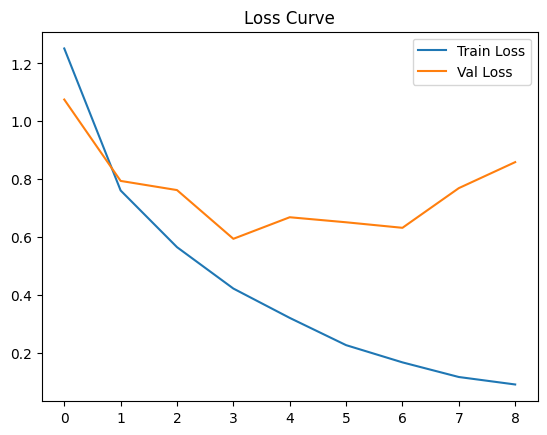

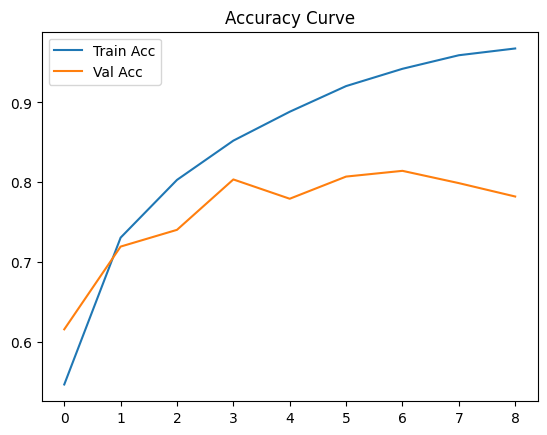

In [ ]:
plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()


In [ ]:
test_loss, test_acc = evaluate(model, test_loader)
print("Baseline Test Accuracy:", test_acc)


Baseline Test Accuracy: 0.7832


Failure case discovery

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

mean = torch.tensor((0.4914, 0.4822, 0.4465)).view(3,1,1)
std  = torch.tensor((0.2470, 0.2435, 0.2616)).view(3,1,1)

def unnormalize(img):
    # img: [3,H,W] tensor normalized
    img = img.cpu() * std + mean
    return img.clamp(0, 1)

def show_img(img, title=""):
    img = unnormalize(img).permute(1,2,0).numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()


In [ ]:
@torch.no_grad()
def collect_top_mistakes(model, loader, top_k=100):
    model.eval()
    mistakes = []
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        probs = F.softmax(logits, dim=1)
        conf, preds = probs.max(dim=1)

        wrong = preds.ne(labels)
        if wrong.any():
            imgs_w = images[wrong].cpu()
            labels_w = labels[wrong].cpu()
            preds_w = preds[wrong].cpu()
            conf_w = conf[wrong].cpu()

            for i in range(imgs_w.size(0)):
                mistakes.append({
                    "img": imgs_w[i],
                    "true": int(labels_w[i]),
                    "pred": int(preds_w[i]),
                    "conf": float(conf_w[i])
                })

    mistakes.sort(key=lambda x: x["conf"], reverse=True)
    return mistakes[:top_k]

mistakes = collect_top_mistakes(model, test_loader, top_k=100)
print("Collected mistakes:", len(mistakes))
print("Top-1 wrong confidence:", mistakes[0]["conf"])


Collected mistakes: 100
Top-1 wrong confidence: 0.9999998807907104


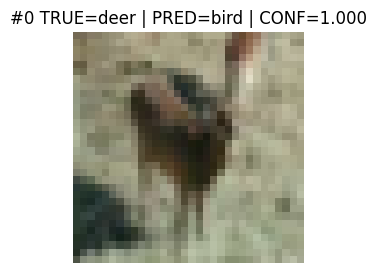

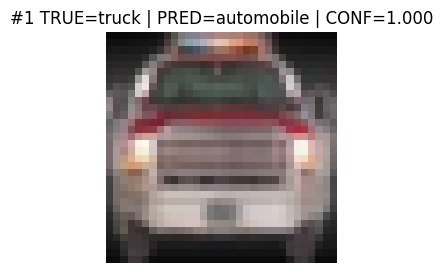

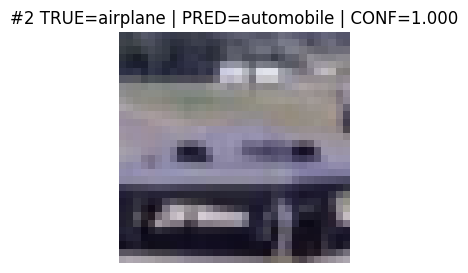

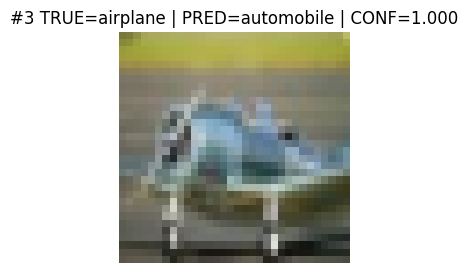

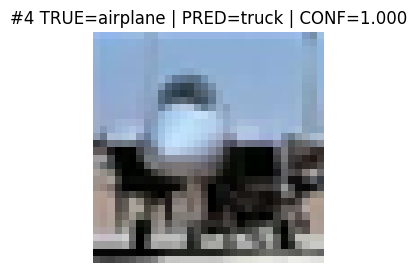

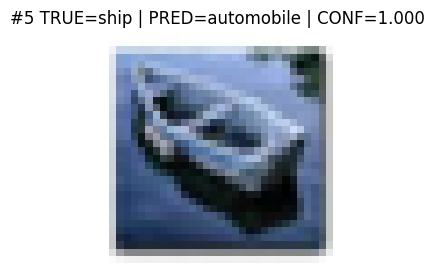

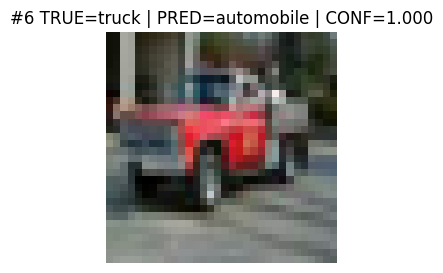

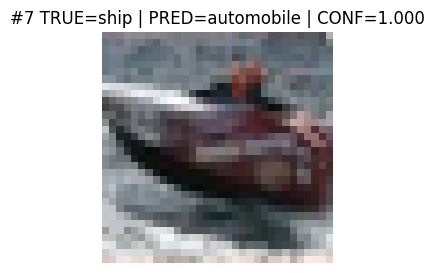

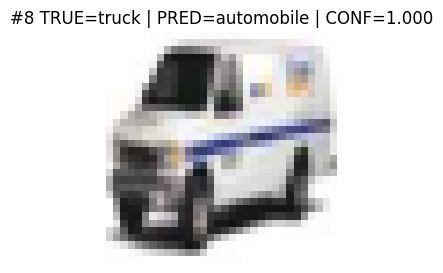

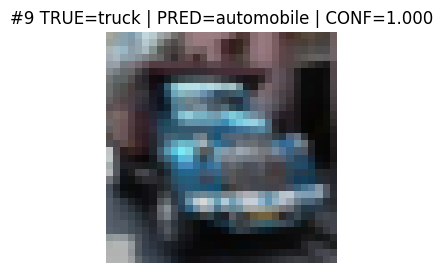

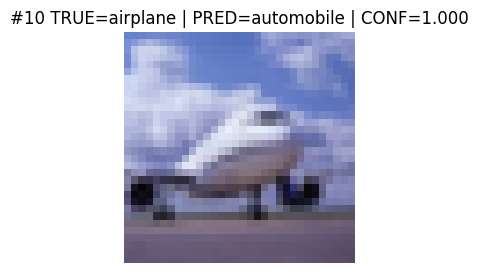

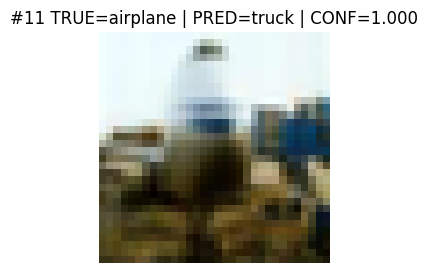

In [ ]:
# classes should already exist from CIFAR-10
for i in range(12):
    m = mistakes[i]
    title = f"#{i} TRUE={classes[m['true']]} | PRED={classes[m['pred']]} | CONF={m['conf']:.3f}"
    show_img(m["img"], title)


In [ ]:
failure_idxs = [0, 3, 9]  # <-- change these after you review images
failure_cases = [mistakes[i] for i in failure_idxs]


GradCam

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        self.target_layer.register_forward_hook(self._forward_hook)
        self.target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out  # keep tensor on device

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate(self, img_tensor, class_idx=None):
        """
        img_tensor: [3,H,W] normalized CPU tensor
        returns: cam (H',W') numpy in [0,1], used_class_idx
        """
        self.model.eval()
        x = img_tensor.unsqueeze(0).to(device)

        logits = self.model(x)
        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()

        self.model.zero_grad()
        score = logits[0, class_idx]
        score.backward()

        # GAP over gradients -> weights
        grads = self.gradients        # [1,C,H,W]
        acts  = self.activations      # [1,C,H,W]
        weights = grads.mean(dim=(2,3), keepdim=True)  # [1,C,1,1]
        cam = (weights * acts).sum(dim=1, keepdim=True)  # [1,1,H,W]
        cam = F.relu(cam)

        cam = cam[0,0].detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam, class_idx

def overlay_cam(img_tensor, cam, title=""):
    img = unnormalize(img_tensor).permute(1,2,0).numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.imshow(cam, alpha=0.45)  # professional overlay
    plt.axis("off")
    plt.title(title)
    plt.show()


In [ ]:
target_layer = model.layer4[-1].conv2
cam_engine = GradCAM(model, target_layer)


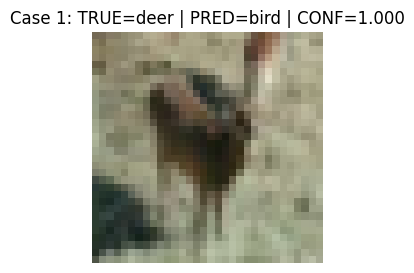

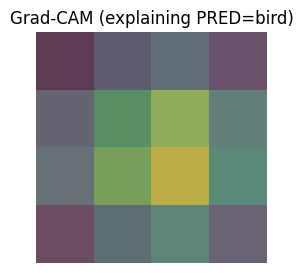

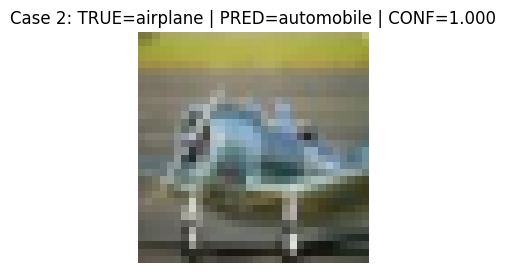

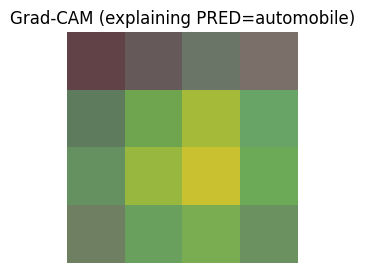

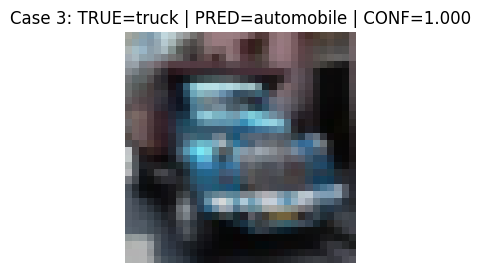

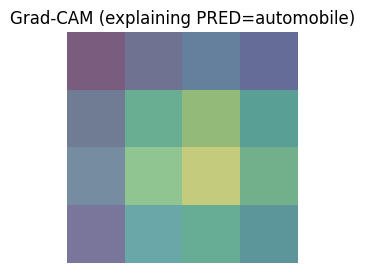

In [ ]:
for idx, fc in enumerate(failure_cases, 1):
    true_name = classes[fc["true"]]
    pred_name = classes[fc["pred"]]

    # show original
    show_img(fc["img"], f"Case {idx}: TRUE={true_name} | PRED={pred_name} | CONF={fc['conf']:.3f}")

    # Grad-CAM for the WRONG predicted class (important for failure analysis)
    cam, used_class = cam_engine.generate(fc["img"], class_idx=fc["pred"])
    overlay_cam(fc["img"], cam, f"Grad-CAM (explaining PRED={classes[used_class]})")


weight decay

In [ ]:
# Reinitialize model (important!)
set_seed(SEED)
model_wd = get_resnet18_cifar().to(device)

EPOCHS = 30
optimizer_wd = torch.optim.Adam(model_wd.parameters(), lr=0.001, weight_decay=1e-4)

history_wd = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

# for epoch in range(EPOCHS):
#     train_loss, train_acc = train_one_epoch(model_wd, train_loader, optimizer_wd)
#     val_loss, val_acc = evaluate(model_wd, val_loader)

#     history_wd["train_loss"].append(train_loss)
#     history_wd["train_acc"].append(train_acc)
#     history_wd["val_loss"].append(val_loss)
#     history_wd["val_acc"].append(val_acc)

#     print(f"Epoch {epoch+1}/{EPOCHS}")
#     print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
#     print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
set_seed(SEED)
model_wd = get_resnet18_cifar().to(device)

optimizer_wd = torch.optim.Adam(
    model_wd.parameters(),
    lr=0.001,
    weight_decay=1e-4
)

history_wd = train_with_early_stopping(
    model_wd,
    train_loader,
    val_loader,
    optimizer_wd,
    epochs=30,
    patience=5
)


Epoch 1/30
Train Loss: 1.2442 | Train Acc: 0.5478
Val Loss: 1.0976 | Val Acc: 0.6078
Validation improved → Saving best model
Epoch 2/30
Train Loss: 0.7831 | Train Acc: 0.7223
Val Loss: 0.8316 | Val Acc: 0.6988
Validation improved → Saving best model
Epoch 3/30
Train Loss: 0.6017 | Train Acc: 0.7887
Val Loss: 0.8627 | Val Acc: 0.7110
No improvement. Patience: 1/5
Epoch 4/30
Train Loss: 0.4832 | Train Acc: 0.8322
Val Loss: 0.7236 | Val Acc: 0.7626
Validation improved → Saving best model
Epoch 5/30
Train Loss: 0.4004 | Train Acc: 0.8600
Val Loss: 0.6602 | Val Acc: 0.7774
Validation improved → Saving best model
Epoch 6/30
Train Loss: 0.3342 | Train Acc: 0.8819
Val Loss: 0.5502 | Val Acc: 0.8122
Validation improved → Saving best model
Epoch 7/30
Train Loss: 0.2735 | Train Acc: 0.9049
Val Loss: 0.5853 | Val Acc: 0.8120
No improvement. Patience: 1/5
Epoch 8/30
Train Loss: 0.2185 | Train Acc: 0.9244
Val Loss: 0.5965 | Val Acc: 0.8068
No improvement. Patience: 2/5
Epoch 9/30
Train Loss: 0.1895 

In [ ]:
test_loss_wd, test_acc_wd = evaluate(model_wd, test_loader)

print("Baseline Test Accuracy:", test_acc)
print("Weight Decay Test Accuracy:", test_acc_wd)


Baseline Test Accuracy: 0.7832
Weight Decay Test Accuracy: 0.7936


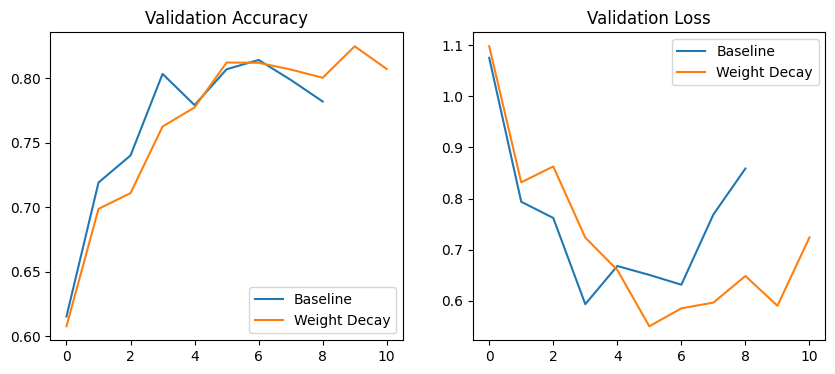

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history["val_acc"], label="Baseline")
plt.plot(history_wd["val_acc"], label="Weight Decay")
plt.title("Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["val_loss"], label="Baseline")
plt.plot(history_wd["val_loss"], label="Weight Decay")
plt.title("Validation Loss")
plt.legend()

plt.show()


In [ ]:
@torch.no_grad()
def predict_single(model, img_tensor):
    model.eval()
    x = img_tensor.unsqueeze(0).to(device)
    probs = F.softmax(model(x), dim=1)[0].cpu()
    conf, pred = probs.max(dim=0)
    return int(pred), float(conf)

print("=== Failure Case Comparison ===")

for i, fc in enumerate(failure_cases, 1):
    true_label = classes[fc["true"]]

    # Baseline
    b_pred, b_conf = predict_single(model, fc["img"])

    # Weight Decay
    w_pred, w_conf = predict_single(model_wd, fc["img"])

    print(f"\nCase {i} (TRUE = {true_label})")
    print(f"Baseline: {classes[b_pred]} | Conf: {b_conf:.3f}")
    print(f"Weight Decay: {classes[w_pred]} | Conf: {w_conf:.3f}")


=== Failure Case Comparison ===

Case 1 (TRUE = deer)
Baseline: bird | Conf: 1.000
Weight Decay: deer | Conf: 0.957

Case 2 (TRUE = airplane)
Baseline: automobile | Conf: 1.000
Weight Decay: automobile | Conf: 0.984

Case 3 (TRUE = truck)
Baseline: automobile | Conf: 1.000
Weight Decay: truck | Conf: 0.977


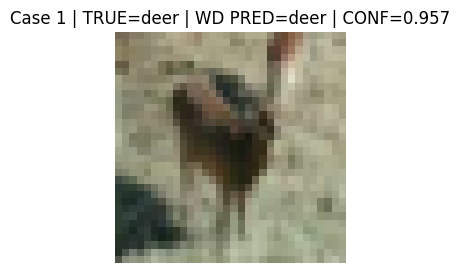

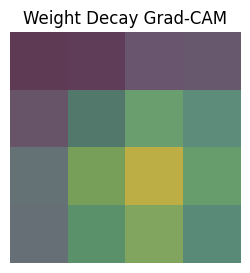

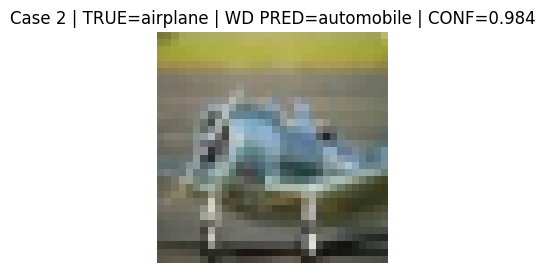

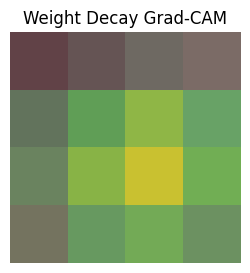

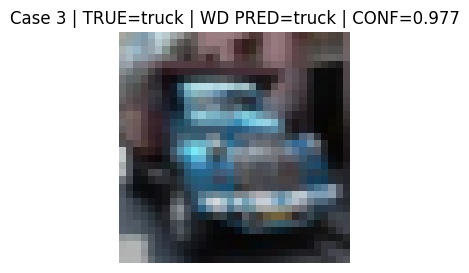

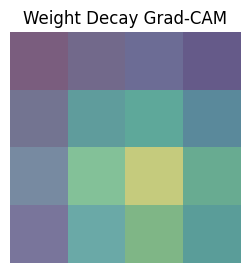

In [ ]:
target_layer_wd = model_wd.layer4[-1].conv2
cam_engine_wd = GradCAM(model_wd, target_layer_wd)

for idx, fc in enumerate(failure_cases, 1):
    true_name = classes[fc["true"]]

    pred_wd, conf_wd = predict_single(model_wd, fc["img"])

    show_img(fc["img"], f"Case {idx} | TRUE={true_name} | WD PRED={classes[pred_wd]} | CONF={conf_wd:.3f}")

    cam, _ = cam_engine_wd.generate(fc["img"], class_idx=pred_wd)
    overlay_cam(fc["img"], cam, "Weight Decay Grad-CAM")


behaviour change analysis

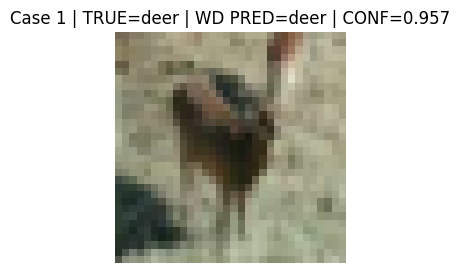

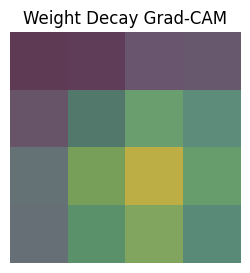

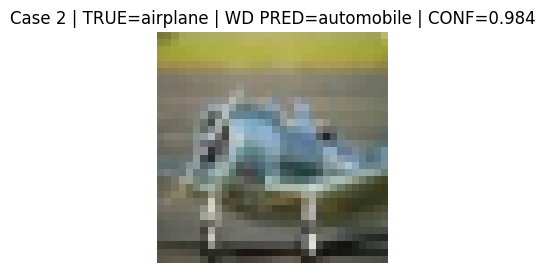

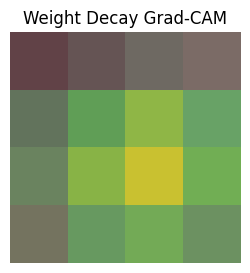

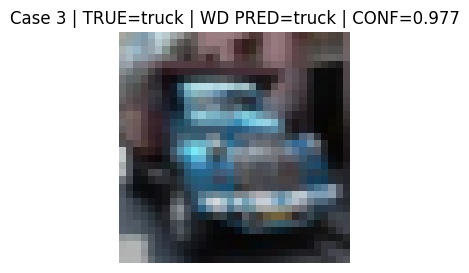

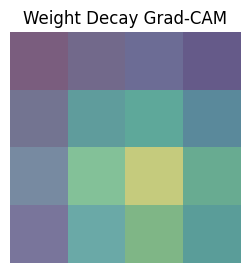

In [ ]:
target_layer_wd = model_wd.layer4[-1].conv2
cam_engine_wd = GradCAM(model_wd, target_layer_wd)

for idx, fc in enumerate(failure_cases, 1):
    true_name = classes[fc["true"]]

    pred_wd, conf_wd = predict_single(model_wd, fc["img"])

    show_img(fc["img"],
             f"Case {idx} | TRUE={true_name} | WD PRED={classes[pred_wd]} | CONF={conf_wd:.3f}")

    cam, _ = cam_engine_wd.generate(fc["img"], class_idx=pred_wd)
    overlay_cam(fc["img"], cam, "Weight Decay Grad-CAM")
